In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_datasets_path = '/content/drive/MyDrive/LSMADEVOIR/homework2/'

#  Flowers and Histograms – Building An Image Search Engine in Python

# The goal

# Step #1: The Descriptor – A 3D RGB Color Histogram

Our image descriptor is a 3D color histogram in the RGB color space with 8 bins per red, green, and blue channel. The best way to explain a 3D histogram is to use the conjunctive AND. This image descriptor will ask a given image how many pixels have a Red value that falls into bin #1 AND a Green value that falls into bin #2 AND how many Blue pixels falls into bin #1. This process will be repeated for each combination of bins; however, it will be done in a computationally efficient manner. When computing a 3D histogram with 8 bins, OpenCV will store the feature vector as an (8, 8, 8) array. We’ll simply flatten it and reshape it to (512,). Once it’s flattened, we can easily compare feature vectors together for similarity.

In [ ]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt

class RGBHistogram:
    def __init__(self, bins):
        # store the number of bins the histogram will use
        self.bins = bins

    def describe(self, image):
        # resize the image to a standard size
        image = cv2.resize(image, (300, 300))
        # compute a 3D histogram in the RGB colorspace,
        # then normalize the histogram so that images
        # with the same content, but either scaled larger
        # or smaller will have (roughly) the same histogram
        hist = cv2.calcHist([image], [0, 1, 2],
                            None, self.bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist)

        # return out 3D histogram as a flattened array
        return hist.flatten()

# Step #2: Indexing our Dataset

We’ve decided that our image descriptor is a 3D RGB histogram. The next step is to apply our image descriptor to each image in the dataset.

This simply means that we are going to loop over our 2000 image dataset, extract a 3D RGB histogram from each image, store the features in a dictionary, and write the dictionary to file.

In reality, you can make indexing as simple or complex as you want. Indexing is a task that is easily made parallel. If we had a four core machine, we could divide the work up between the four cores and speedup the indexing process.

In [ ]:
# import the necessary packages
import pickle
import glob
import os

# Data names and locations
dataset_location = main_datasets_path+"images"
index_name = "rgb_histogram_index"

# initialize the index dictionary to store our our quantifed
# images, with the 'key' of the dictionary being the image
# filename and the 'value' our computed features
# Initialize the index dictionary
index = {}

# Initialize our image descriptor
desc = RGBHistogram([8, 8, 8])

# Loop over the images in the dataset
for imagePath in glob.glob(dataset_location + os.sep + "*.jpg"):
    # Extract the unique image ID (i.e., the filename)
    k = imagePath[imagePath.rfind(os.sep) + 1:]
    # Load the image, describe it using our RGB histogram
    # descriptor, and update the index
    image = cv2.imread(imagePath)
    features = desc.describe(image)
    index[k] = features

# Write the index to disk
outputFile = open(index_name + ".pkl", "wb")
pickle.dump(index, outputFile)
outputFile.close()
print("Done...indexed %d images" % (len(index)))
print("done...indexed %d images" % (len(index)))

Done...indexed 2055 images
done...indexed 2055 images


# Step #3: The Search

We now have our index sitting on disk, ready to be searched.

The problem is, we need some code to perform the actual search. How are we going to compare two feature vectors and how are we going to determine how similar they are?

This question is better addressed first with some code, then I’ll break it down.

In [ ]:
class Searcher:
    def __init__(self, index):
        # store our index of images
        self.index = index

    def search(self, queryFeatures):
        # initialize our dictionary of results
        results = {}
        # loop over the index
        for (k, features) in self.index.items():
            # compute the chi-squared distance between the features
            # in our index and our query features -- using the
            # chi-squared distance which is normally used in the
            # computer vision field to compare histograms
            d = self.chi2_distance(features, queryFeatures)
            # now that we have the distance between the two feature
            # vectors, we can udpate the results dictionary -- the
            # key is the current image ID in the index and the
            # value is the distance we just computed, representing
            # how 'similar' the image in the index is to our query
            results[k] = d
        # sort our results, so that the smaller distances (i.e. the
        # more relevant images are at the front of the list)
        results = sorted([(v, k) for (k, v) in results.items()])
        # return our results
        return results

    def chi2_distance(self, histA, histB, eps=1e-10):
        # compute the chi-squared distance
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
                          for (a, b) in zip(histA, histB)])
        # return the chi-squared distance
        return d

# Step #4: Performing a Search

Finally. We are closing in on a functioning image search engine.



This code creates an image collage to display the results of an image search, resizing and organizing the images to present them in a concise and visually clear manner.

The code dynamically calculates the number of rows and columns needed based on the number of images to display (up to a maximum of 10).
It resizes each image to fit the size of a cell in the collage.
The images are placed in the collage based on their position in the list of results.
The images are displayed in a linear order, meaning the first images appear in the top-left and subsequent ones are added from left to right, top to bottom.
The final collage displays up to 10 images, organized neatly in a single visualization, facilitating examination and comparison of the search results.

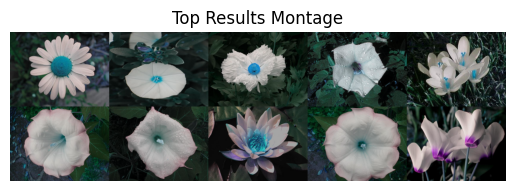

In [ ]:
# Calculate the number of rows and columns for the montage
num_images = min(len(results), 10)  # We'll display up to top 10 results
num_cols = 5  # Number of columns for each montage
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

# Calculate the width and height of each montage cell based on the dimensions of the first image
first_image_path = dataset_location + os.sep + "%s" % (results[0][1])
first_image = cv2.imread(first_image_path)
cell_height, cell_width, _ = first_image.shape

# Initialize the montage array
montage = np.zeros((cell_height * num_rows, cell_width * num_cols, 3), dtype="uint8")

# Loop over the top results
for i in range(num_images):
    # Grab the result
    (score, imageName) = results[i]
    path = dataset_location + os.sep + "%s" % (imageName)
    result = cv2.imread(path)

    # Calculate the row and column indices for the current image
    row = i // num_cols
    col = i % num_cols

    # Compute the starting and ending pixel coordinates for the current cell in the montage
    start_y = row * cell_height
    end_y = start_y + cell_height
    start_x = col * cell_width
    end_x = start_x + cell_width

    # Resize the result image to fit the cell dimensions
    result = cv2.resize(result, (cell_width, cell_height))

    # Update the montage with the current result image
    montage[start_y:end_y, start_x:end_x] = result

# Show the montage
plt.figure()
plt.imshow(montage)
plt.title("Top Results Montage")
plt.axis("off")
plt.show()

External Queries

As of right now, I’ve only shown you how to perform a search using images that are already in your index. But clearly, this is not how all image search engines work. Google allows you to upload an image of your own. Why can’t we? Let’s see how we can perform a search using an image that we haven’t already indexed:

there are nevertheless some failures.

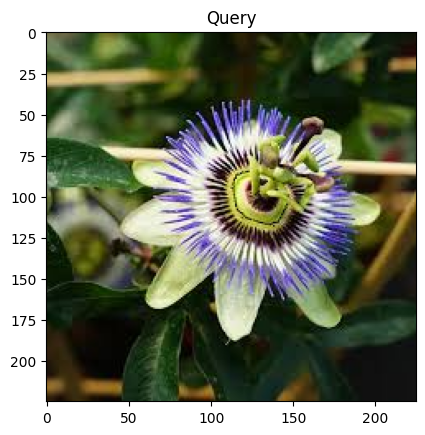

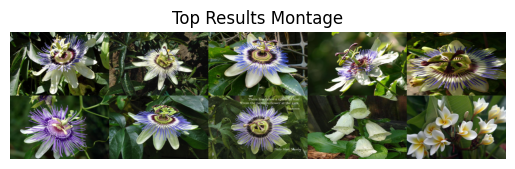

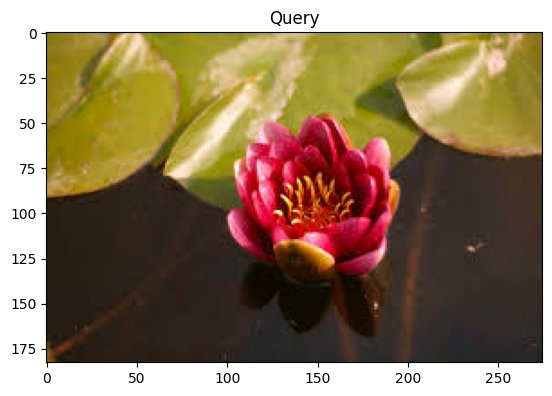

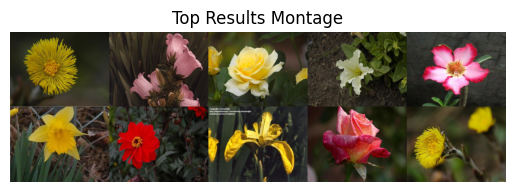

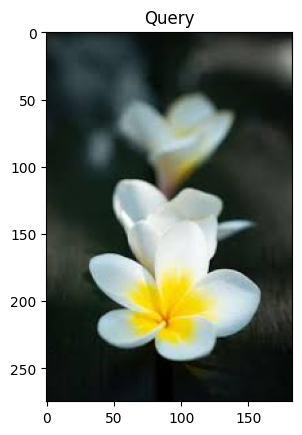

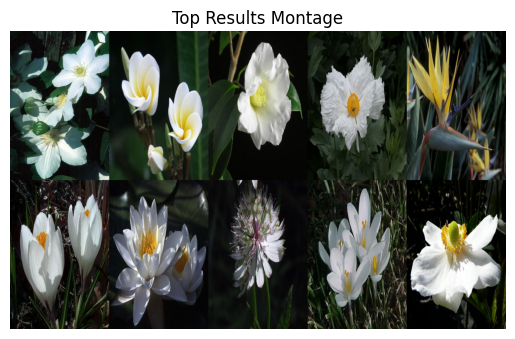

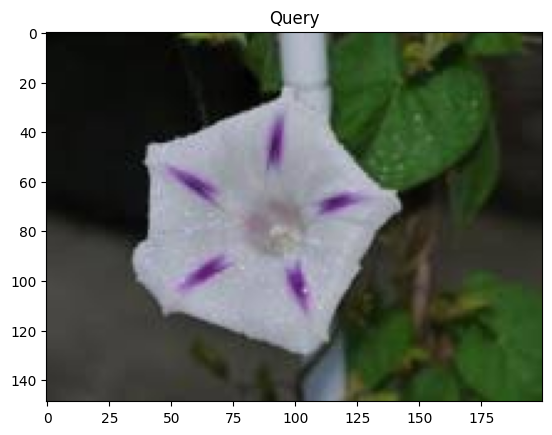

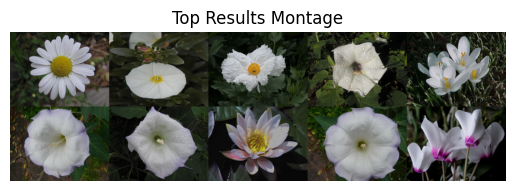

In [ ]:
import os

# Chemin d'accès au dossier des requêtes
queries_folder = main_datasets_path + "queries"

# Récupérer la liste des fichiers dans le dossier des requêtes
query_images = os.listdir(queries_folder)

# Boucler sur chaque image de requête
for query_image_name in query_images:
    # Construire le chemin d'accès complet de l'image de requête
    query_location = os.path.join(queries_folder, query_image_name)

    # Charger et afficher l'image de requête
    queryImage = cv2.imread(query_location)
    if queryImage is None:
        print(f"Erreur: Impossible de charger l'image de requête {query_image_name}")
        continue

    plt.figure()
    plt.title("Query")
    plt.imshow(cv2.cvtColor(queryImage, cv2.COLOR_BGR2RGB))  # Convertir BGR en RGB pour l'affichage
    plt.show()

    # Décrire la requête de la même manière que dans l'index.py - un histogramme RGB 3D avec 8 bacs par canal
    desc = RGBHistogram([8, 8, 8])
    queryFeatures = desc.describe(queryImage)

    # Charger l'index et effectuer la recherche
    file = open(index_name + ".pkl", 'rb')
    index = pickle.load(file)
    searcher = Searcher(index)
    results = searcher.search(queryFeatures)

    # Initialiser le montage pour afficher les résultats
    num_images = min(len(results), 10)  # Afficher jusqu'à 10 résultats
    num_cols = 5  # Nombre de colonnes pour chaque montage
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaires

    # Calculer la largeur et la hauteur de chaque cellule de montage en fonction des dimensions de la première image
    first_image_path = os.path.join(dataset_location, results[0][1])
    first_image = cv2.imread(first_image_path)
    cell_height, cell_width, _ = first_image.shape

    # Initialiser le tableau montage
    montage = np.zeros((cell_height * num_rows, cell_width * num_cols, 3), dtype="uint8")

    # Boucler sur les résultats pour créer le montage
    for i in range(num_images):
        (score, imageName) = results[i]
        path = os.path.join(dataset_location, imageName)
        result = cv2.imread(path)

        row = i // num_cols
        col = i % num_cols

        start_y = row * cell_height
        end_y = start_y + cell_height
        start_x = col * cell_width
        end_x = start_x + cell_width

        result = cv2.resize(result, (cell_width, cell_height))

        montage[start_y:end_y, start_x:end_x] = result

    # Afficher le montage
    plt.figure()
    plt.imshow(cv2.cvtColor(montage, cv2.COLOR_BGR2RGB))  # Convertir BGR en RGB pour l'affichage
    plt.title("Top Results Montage")
    plt.axis("off")
    plt.show()